# BA plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import rcParams, ticker
from matplotlib.ticker import MultipleLocator, FuncFormatter

# Use a different serif font (DejaVu Serif is widely available)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],  # Use DejaVu Serif instead of Latin Modern
    "mathtext.fontset": "cm",        # Keep LaTeX-style math font
    "axes.unicode_minus": True       # Ensure unicode minus is used
})

rcParams['axes.labelsize'] = 12
rcParams['legend.fontsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12


import pandas as pd
from rdmulti import rdmc, rdms, rdmcplot
import statsmodels.api as sm
import math

def round_up_to(x, base=5):
    return int(math.ceil(x / float(base)) * base)

# plotting
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# Set color cycle
cmap = plt.colormaps['Set3']
colors = cmap(np.linspace(0, 1, 5))   # 5 distinct colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

In [2]:
# import exceldata
df = pd.read_excel("Hjemsendelse 05-11-2025.xlsx", sheet_name="Deskr. data")

#gen bs/sqm variable
df['bs_per_sqm'] = df['bs'] / df['sqm']

#gen rent/sqm variable
df['rent_per_sqm'] = df['leje'] / df['sqm']

df.head(10)

,sqm,N,alder,ind,bs,leje,leje pr. kvm,bs_per_sqm,rent_per_sqm
0,20,442,24.635747,120955.663268,428.013940,2795.456825,139.772841,21.400697,139.772841
1,21,333,23.897898,110404.234872,401.531047,2588.492242,123.261535,19.120526,123.261535
2,22,705,24.001418,103208.919395,400.685884,2587.115366,117.596153,18.212995,117.596153
3,23,423,23.787234,111960.343180,404.620377,2620.367415,113.929018,17.592190,113.929018
4,24,2891,23.728814,105852.409412,393.462648,2569.160008,107.048334,16.394277,107.048334
5,25,3064,23.765339,109654.147455,406.518298,2844.575908,113.783036,16.260732,113.783036
6,26,2734,23.607169,112851.902593,440.289638,2864.328548,110.166483,16.934217,110.166483
7,27,4643,23.505277,108512.529990,416.087221,2709.395506,100.347982,15.410638,100.347982
8,28,6449,23.578074,111062.479167,405.699558,2604.982426,93.035087,14.489270,93.035087
9,29,5142,23.293466,109241.895713,411.136372,2640.930021,91.066552,14.177116,91.066552


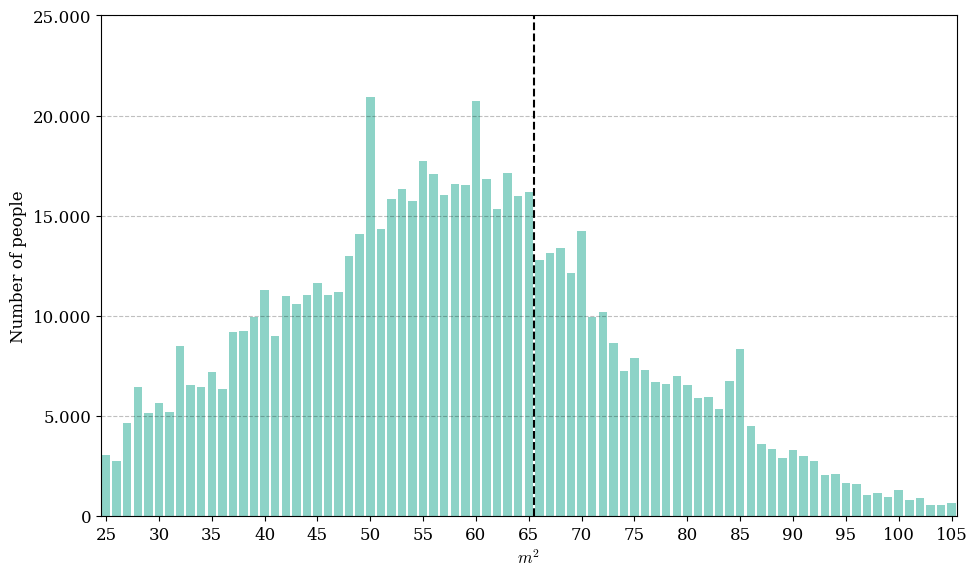

In [3]:
#Plot N on sqm
df = df.sort_values(by="sqm")

#size
plt.figure(figsize=(10,6))
ax = plt.gca()

plt.xlim(24.5, 105.5) # limit x-axis to 55-75 sqm
plt.xticks(np.arange(25, 105.01, 5))  # limit x-axis to 55-75 sqm

plt.ylim(0, 25) # limit x-axis to 55-75 sqm
plt.yticks(np.arange(0, 25000.01, 5000))  # limit x-axis to 55-75 sqm
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", ".")))

# formatting
# plt.title('People per sqm')
plt.xlabel('$m^2$')
plt.ylabel('Number of people')
plt.grid(axis='x')

# plot bars
plt.bar(df['sqm'], df['N'])

# vertical line at midpoint
midpoint = 65.5 
plt.axvline(x=midpoint, color='black', linestyle='--')

plt.tight_layout()
plt.show()

/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/3988547642.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/3988547642.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


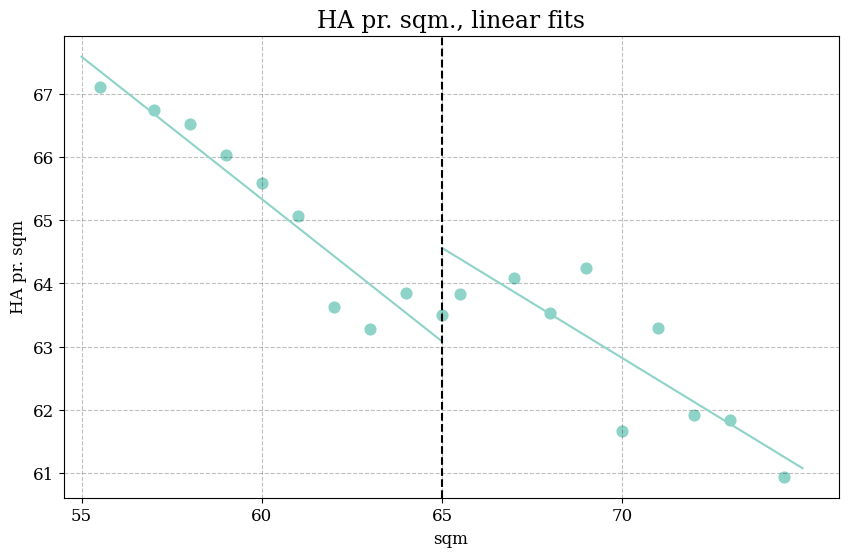

In [4]:
# First stage plot with linear (p=1) fits

bw = 10

# --- 1. Subset for RD window ---
df_left = df[(df['sqm'] >= 65 - bw) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 65) & (df['sqm'] <= 65 + bw)].copy()

# --- 2. Binscatter means ---
def binscatter(data, x, y, bins=bw*2):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bins)
    out = data.groupby('bin').agg(mean_x=(x, 'mean'), mean_y=(y, 'mean')).dropna()
    return out

bin_left = binscatter(df_left, 'sqm', 'rent_per_sqm', bins=bw)
bin_right = binscatter(df_right, 'sqm', 'rent_per_sqm', bins=bw-1)

# --- 3. Two separate regressions ---
def linreg(df_bin):
    X = sm.add_constant(df_bin['mean_x'])
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model.params['const'], model.params['mean_x']

a_L, b_L = linreg(bin_left)
a_R, b_R = linreg(bin_right)

# --- 4. Plot ---
plt.figure(figsize=(10,6))

# binscatter points
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=60, color = colors[0])
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=60, color = colors[0])

# left regression line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
yL = a_L + b_L * xL
plt.plot(xL, yL, color = colors[0])

# right regression line
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)
yR = a_R + b_R * xR
plt.plot(xR, yR, color = colors[0])

# --- 5. Cutoff line ---
cut = 65
plt.axvline(x=cut, linestyle='--', color='black')

# Aesthetics
plt.xlabel('sqm')
plt.ylabel('HA pr. sqm')
plt.title('HA pr. sqm., linear fits')
plt.grid(True)
plt.xticks(np.arange(65 - bw, 65 + bw, 5))
plt.xlim(65 - bw - .5, 65 + bw + 1)

plt.show()

/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/3192677360.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/3192677360.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


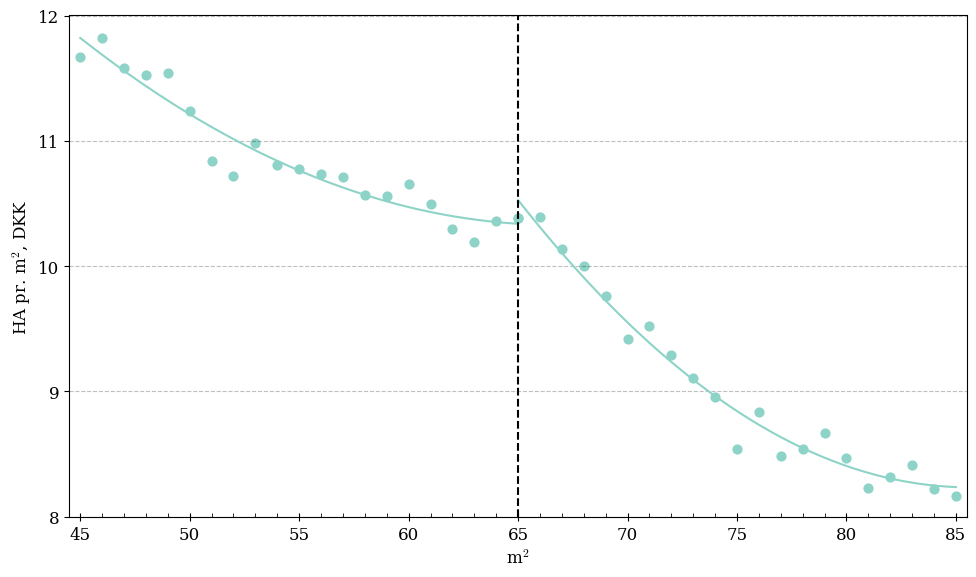

In [5]:
# First stage plot with polynomial (p=2) fits

bw = 20

# --- 1. Subset for RD window (55–75 sqm, change if needed) ---
df_left = df[(df['sqm'] >= 65 - bw) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 65) & (df['sqm'] <= 65 + bw)].copy()

# --- 2. Binscatter helper ---
def binscatter(data, x, y, bins=bw*2):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bw*2)
    return data.groupby('bin').agg(mean_x=(x, 'mean'),
                                   mean_y=(y, 'mean')).dropna()

bin_left = binscatter(df_left, 'sqm', 'bs_per_sqm', bins=8)
bin_right = binscatter(df_right, 'sqm', 'bs_per_sqm', bins=8)

# --- 3. Polynomial regression (p = 2) on each side ---
def poly_reg(df_bin):
    df_bin = df_bin.copy()
    df_bin['x2'] = df_bin['mean_x']**2               # quadratic term
    X = sm.add_constant(df_bin[['mean_x', 'x2']])    # const + x + x^2
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model

model_L = poly_reg(bin_left)
model_R = poly_reg(bin_right)

# Extract coefficients
a_L = model_L.params['const']
b_L1 = model_L.params['mean_x']
b_L2 = model_L.params['x2']

a_R = model_R.params['const']
b_R1 = model_R.params['mean_x']
b_R2 = model_R.params['x2']

# --- 4. Plot binscatter + polynomial fit ---
plt.figure(figsize=(10,6))

# Scatter points (binned means)
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=40, color = colors[0])
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=40, color = colors[0])

# Left polynomial line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
yL = a_L + b_L1*xL + b_L2*xL**2
plt.plot(xL, yL, color = colors[0])

# Right polynomial line
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)
yR = a_R + b_R1*xR + b_R2*xR**2
plt.plot(xR, yR, color = colors[0])

# --- Cutoff line ---
cut = 65  # halfway between bins
plt.axvline(x=cut, linestyle='--', color='black')

# Formatting
plt.xlabel('m$^2$')
plt.ylabel('HA pr. m$^2$, DKK')
plt.title('')

#x-axis ticks
plt.xlim(65 - bw - .5, 65 + bw + 0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.tick_params(axis='x', which='major', length=6, direction='inout')   # long ticks
ax.tick_params(axis='x', which='minor', length=3, direction='in')   # short ticks

#y-axis ticks
plt.ylim(8, 12)
plt.yticks(np.arange(8, 12.01, 1))

# only horizontal lines
plt.grid(axis='x')   

plt.tight_layout()
plt.show()

/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/2753163048.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/2753163048.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


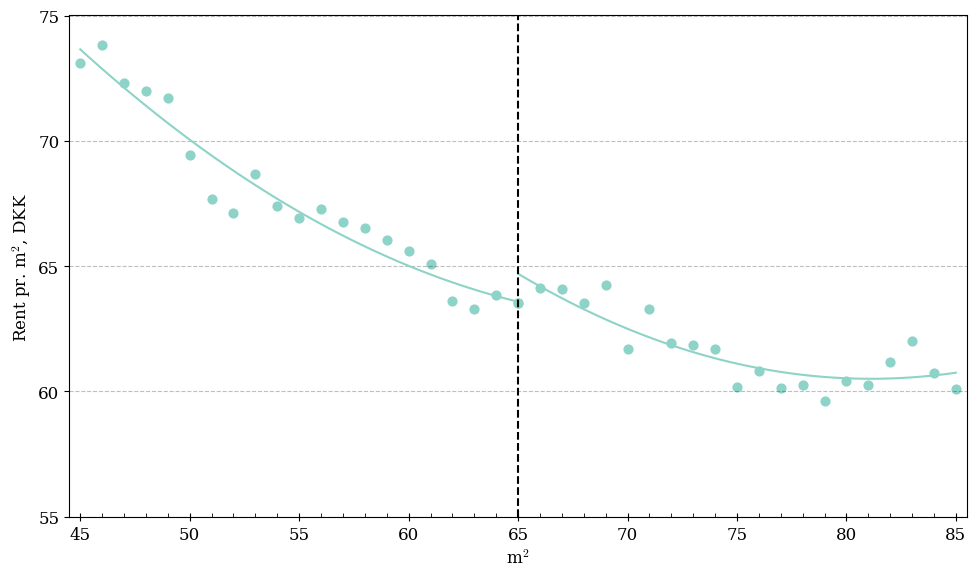

In [6]:
# Reduced form with polynomial (p=2) fits

bw = 20

# --- 1. Subset for RD window (55–75 sqm, change if needed) ---
df_left = df[(df['sqm'] >= 65 - bw) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 65) & (df['sqm'] <= 65 + bw)].copy()

# --- 2. Binscatter helper ---
def binscatter(data, x, y, bins=bw*2):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bw*2)
    return data.groupby('bin').agg(mean_x=(x, 'mean'),
                                   mean_y=(y, 'mean')).dropna()

bin_left = binscatter(df_left, 'sqm', 'rent_per_sqm', bins=8)
bin_right = binscatter(df_right, 'sqm', 'rent_per_sqm', bins=8)

# --- 3. Polynomial regression (p = 2) on each side ---
def poly_reg(df_bin):
    df_bin = df_bin.copy()
    df_bin['x2'] = df_bin['mean_x']**2               # quadratic term
    X = sm.add_constant(df_bin[['mean_x', 'x2']])    # const + x + x^2
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model

model_L = poly_reg(bin_left)
model_R = poly_reg(bin_right)

# Extract coefficients
a_L = model_L.params['const']
b_L1 = model_L.params['mean_x']
b_L2 = model_L.params['x2']

a_R = model_R.params['const']
b_R1 = model_R.params['mean_x']
b_R2 = model_R.params['x2']

# --- 4. Plot binscatter + polynomial fit ---
plt.figure(figsize=(10,6))

# Scatter points (binned means)
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=40, color = colors[0])
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=40, color = colors[0])

# Left polynomial line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
yL = a_L + b_L1*xL + b_L2*xL**2
plt.plot(xL, yL, color = colors[0])

# Right polynomial line
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)
yR = a_R + b_R1*xR + b_R2*xR**2
plt.plot(xR, yR, color = colors[0])

# --- Cutoff line ---
cut = 65  # halfway between bins
plt.axvline(x=cut, linestyle='--', color='black')

#x-axis ticks
plt.xlim(65 - bw - .5, 65 + bw + 0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.tick_params(axis='x', which='major', length=6, direction='inout')   # long ticks
ax.tick_params(axis='x', which='minor', length=3, direction='in')   # short ticks

#y-axis ticks
plt.ylim(55, 75)
plt.yticks(np.arange(55, 75.001, 5))

# Formatting
plt.xlabel('m$^2$')
plt.ylabel('Rent pr. m$^2$, DKK')
plt.title('')

# only horizontal lines
plt.grid(axis='x')   

plt.tight_layout()
plt.show()

/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/2767813206.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/2767813206.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/2767813206.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h000

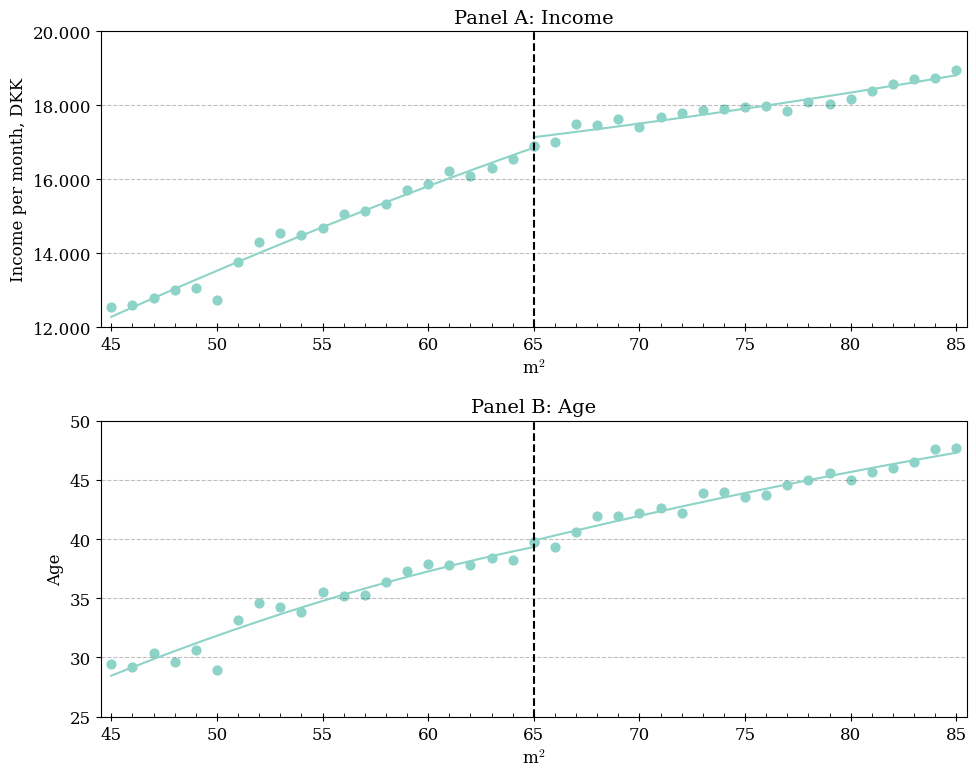

In [7]:
bw = 20

# -------------------------------------------------------------------
# 1. Prepare data
# -------------------------------------------------------------------

df['ind_m'] = df['ind'] / 12

df_left  = df[(df['sqm'] >= 65 - bw) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 65) & (df['sqm'] <= 65 + bw)].copy()

def binscatter(data, x, y, bins=bw*2):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bw*2)
    return data.groupby('bin').agg(mean_x=(x, 'mean'),
                                   mean_y=(y, 'mean')).dropna()

# -------------------------------------------------------------------
# 2. Income bins + regression
# -------------------------------------------------------------------

bin_left_inc = binscatter(df_left, 'sqm', 'ind_m')
bin_right_inc = binscatter(df_right, 'sqm', 'ind_m')

def poly_reg(df_bin):
    df_bin = df_bin.copy()
    df_bin['x2'] = df_bin['mean_x']**2
    X = sm.add_constant(df_bin[['mean_x', 'x2']])
    return sm.OLS(df_bin['mean_y'], X).fit()

model_L_inc = poly_reg(bin_left_inc)
model_R_inc = poly_reg(bin_right_inc)

aL_i, bL1_i, bL2_i = model_L_inc.params['const'], model_L_inc.params['mean_x'], model_L_inc.params['x2']
aR_i, bR1_i, bR2_i = model_R_inc.params['const'], model_R_inc.params['mean_x'], model_R_inc.params['x2']

# -------------------------------------------------------------------
# 3. Age bins + regression
# -------------------------------------------------------------------

bin_left_age = binscatter(df_left, 'sqm', 'alder')
bin_right_age = binscatter(df_right, 'sqm', 'alder')

model_L_age = poly_reg(bin_left_age)
model_R_age = poly_reg(bin_right_age)

aL_a, bL1_a, bL2_a = model_L_age.params['const'], model_L_age.params['mean_x'], model_L_age.params['x2']
aR_a, bR1_a, bR2_a = model_R_age.params['const'], model_R_age.params['mean_x'], model_R_age.params['x2']

# -------------------------------------------------------------------
# 4. Create figure
# -------------------------------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# -------------------------------------------------------------------
# --- TOP PLOT: INCOME ---
# -------------------------------------------------------------------

ax = axes[0]

# Scatter
ax.scatter(bin_left_inc['mean_x'], bin_left_inc['mean_y'], s=40, color=colors[0])
ax.scatter(bin_right_inc['mean_x'], bin_right_inc['mean_y'], s=40, color=colors[0])

# Lines
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)

ax.plot(xL, aL_i + bL1_i*xL + bL2_i*xL**2, color=colors[0])
ax.plot(xR, aR_i + bR1_i*xR + bR2_i*xR**2, color=colors[0])

# Cutoff
ax.axvline(65, linestyle='--', color='black')

# X-ticks (NOW VISIBLE)
ax.set_xlim(65 - bw - 0.5, 65 + bw + 0.5)
ax.xaxis.set_major_locator(MultipleLocator(5))   # 45, 50, 55, 60, 65, 70, 75, 80, 85
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(axis='x', which='major', length=6, direction='inout')
ax.tick_params(axis='x', which='minor', length=3, direction='in')

### FIX HERE — force x-axis numbers to appear on the top plot
ax.tick_params(axis="x", labelbottom=True)

# Y-ticks
ax.set_ylabel("Income per month, DKK")
ax.set_ylim(12000, 20000)
ax.set_yticks(np.arange(12000, 20000.01, 2000))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", ".")))

ax.grid(axis='x')
# X label for bottom subplot
ax.set_xlabel("m$^2$")

#Title
ax.set_title("Panel A: Income", fontsize=14)

# -------------------------------------------------------------------
# --- BOTTOM PLOT: AGE ---
# -------------------------------------------------------------------

ax = axes[1]

# Scatter
ax.scatter(bin_left_age['mean_x'], bin_left_age['mean_y'], s=40, color=colors[0])
ax.scatter(bin_right_age['mean_x'], bin_right_age['mean_y'], s=40, color=colors[0])

# Lines
ax.plot(xL, aL_a + bL1_a*xL + bL2_a*xL**2, color=colors[0])
ax.plot(xR, aR_a + bR1_a*xR + bR2_a*xR**2, color=colors[0])

# Cutoff
ax.axvline(65, linestyle='--', color='black')

# X-ticks (shared with top)
ax.set_xlim(65 - bw - 0.5, 65 + bw + 0.5)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(axis='x', which='major', length=6, direction='inout')
ax.tick_params(axis='x', which='minor', length=3, direction='in')

# Y-ticks
ax.set_ylabel("Age")
ax.set_ylim(25, 50)
ax.set_yticks(np.arange(25, 51, 5))

ax.grid(axis='x')

# X label for bottom subplot
ax.set_xlabel("m$^2$")

# Title
ax.set_title("Panel B: Age", fontsize=14)


# -------------------------------------------------------------------
fig.align_xlabels()
fig.tight_layout()
plt.show()

/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/1235199519.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/1235199519.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


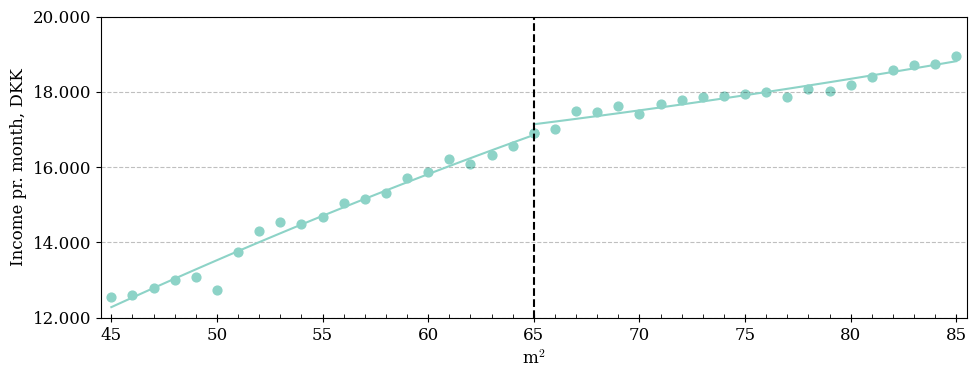

In [8]:
# Binscatter plot with polynomial (p=2) fit for income
bw = 20

#Gen ind pr month variable
df['ind_m'] = df['ind'] / 12

# --- 1. Subset for RD window (55–75 sqm, change if needed) ---
df_left = df[(df['sqm'] >= 65 - bw) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 65) & (df['sqm'] <= 65 + bw)].copy()


# --- 2. Binscatter helper ---
def binscatter(data, x, y, bins= bw*2):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bw*2)
    return data.groupby('bin').agg(mean_x=(x, 'mean'),
                                   mean_y=(y, 'mean')).dropna()

bin_left = binscatter(df_left, 'sqm', 'ind_m', bins=8)
bin_right = binscatter(df_right, 'sqm', 'ind_m', bins=8)

# --- 3. Polynomial regression (p = 2) on each side ---
def poly_reg(df_bin):
    df_bin = df_bin.copy()
    df_bin['x2'] = df_bin['mean_x']**2               # quadratic term
    X = sm.add_constant(df_bin[['mean_x', 'x2']])    # const + x + x^2
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model

model_L = poly_reg(bin_left)
model_R = poly_reg(bin_right)

# Extract coefficients
a_L = model_L.params['const']
b_L1 = model_L.params['mean_x']
b_L2 = model_L.params['x2']

a_R = model_R.params['const']
b_R1 = model_R.params['mean_x']
b_R2 = model_R.params['x2']

# --- 4. Plot binscatter + polynomial fit ---
plt.figure(figsize=(10,4))

# Scatter points (binned means)
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=40, color = colors[0])
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=40, color = colors[0])

# Left polynomial line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
yL = a_L + b_L1*xL + b_L2*xL**2
plt.plot(xL, yL, color = colors[0])

# Right polynomial line
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)
yR = a_R + b_R1*xR + b_R2*xR**2
plt.plot(xR, yR, color = colors[0])

# --- Cutoff line ---
cut = 65
plt.axvline(x=cut, linestyle='--', color='black')

#x-axis ticks
plt.xlim(65 - bw - .5, 65 + bw + 0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.tick_params(axis='x', which='major', length=6, direction='inout')   # long ticks
ax.tick_params(axis='x', which='minor', length=3, direction='in')   # short ticks

# Formatting
plt.xlabel('m$^2$')
plt.ylabel('Income pr. month, DKK')
plt.title('')

#y-axis ticks
plt.ylim(12000, 19000)
plt.yticks(np.arange(12000, 20000.01, 2000))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", ".")))

# only horizontal lines
plt.grid(axis='x') 

plt.tight_layout()
plt.show()

/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/3035304777.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/0r/733_g83n5pj1lk7nwtr3yg_h0000gn/T/ipykernel_81217/3035304777.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


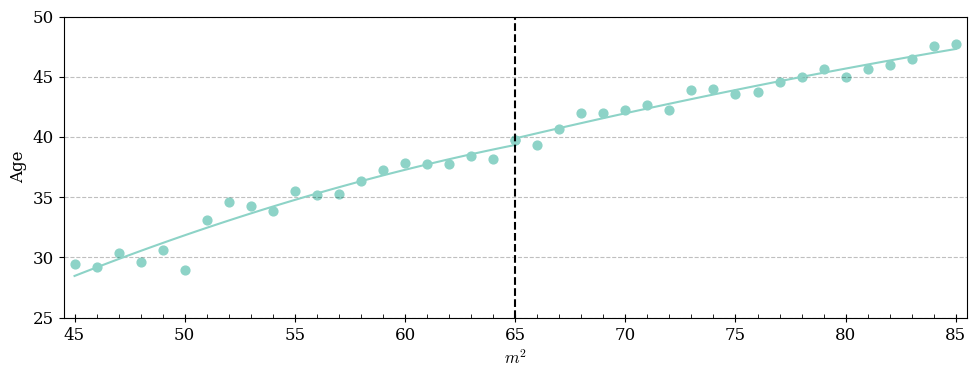

In [9]:
#Binscatter plot with polynomial (p=2) fit for age
bw = 20

# --- 1. Subset for RD window (55–75 sqm, change if needed) ---
df_left = df[(df['sqm'] >= 65 - bw) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 65) & (df['sqm'] <= 65 + bw)].copy()


# --- 2. Binscatter helper ---
def binscatter(data, x, y, bins=bw*2):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bw*2)
    return data.groupby('bin').agg(mean_x=(x, 'mean'),
                                   mean_y=(y, 'mean')).dropna()

bin_left = binscatter(df_left, 'sqm', 'alder', bins=8)
bin_right = binscatter(df_right, 'sqm', 'alder' \
'', bins=8)

# --- 3. Polynomial regression (p = 2) on each side ---
def poly_reg(df_bin):
    df_bin = df_bin.copy()
    df_bin['x2'] = df_bin['mean_x']**2               # quadratic term
    X = sm.add_constant(df_bin[['mean_x', 'x2']])    # const + x + x^2
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model

model_L = poly_reg(bin_left)
model_R = poly_reg(bin_right)

# Extract coefficients
a_L = model_L.params['const']
b_L1 = model_L.params['mean_x']
b_L2 = model_L.params['x2']

a_R = model_R.params['const']
b_R1 = model_R.params['mean_x']
b_R2 = model_R.params['x2']

# --- 4. Plot binscatter + polynomial fit ---
plt.figure(figsize=(10,4))

# Scatter points (binned means)
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=40, color = colors[0])
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=40, color = colors[0])

# Left polynomial line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
yL = a_L + b_L1*xL + b_L2*xL**2
plt.plot(xL, yL, color = colors[0])

# Right polynomial line
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)
yR = a_R + b_R1*xR + b_R2*xR**2
plt.plot(xR, yR, color = colors[0])

# --- Cutoff line ---
cut = 65
plt.axvline(x=cut, linestyle='--', color='black')

# Formatting
plt.xlabel('$m^2$')
plt.ylabel('Age')
plt.title('')

#x-axis ticks
plt.xlim(65 - bw - .5, 65 + bw + 0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.tick_params(axis='x', which='major', length=6, direction='inout')   # long ticks
ax.tick_params(axis='x', which='minor', length=3, direction='in')   # short ticks

#y-axis ticks
plt.ylim(25, 50)
plt.yticks(np.arange(25, 50.001, 5))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}".replace(",", ".")))

plt.grid(axis='x')   # only horizontal lines

plt.tight_layout()
plt.show()

In [10]:
#Defining function to load data and set index
def load_bw_data(sheet, sheet_name):
    df = pd.read_excel(sheet, sheet_name)
    df['upper'] = df['est'] + df['se']*1.96
    df['lower'] = df['est'] - df['se']*1.96
    df.set_index('bw', inplace=True)
    return df

#Defining function to plot estimates with 95% CI
def plot_bw(df, title="Estimates with 95% CI", clr=colors[0], y_min=-5, y_max=5,ticks=1):
    #Gen CI

    #Plot estimate, upper and lower for each bw. The errorbars are dotted lines of the same maint color as the points.
    plt.figure(figsize=(10,6))
    plt.plot(df['est'])
    plt.plot(df['upper'], linestyle='--', color=clr)
    plt.plot(df['lower'], linestyle='--', color=clr)
    plt.axhline(y=0, color='black', linewidth=1) #Plot a fat black horizontal line at y=0

    # Formatting
    #plt.title(title)
    plt.xlabel('Bandwidth')
    plt.ylabel('Estimate')
    
    #X-axis ticks
    plt.xticks(np.arange(3, 14.01, 1))
    plt.xlim(df.index[0], 14)

    #Y-axis ticks
    plt.ylim(y_min, y_max)
    plt.yticks(np.arange(y_min, y_max + 0.00001, ticks))

    plt.tight_layout()

    plt.grid(axis='x')   # only horizontal lines

    plt.show()


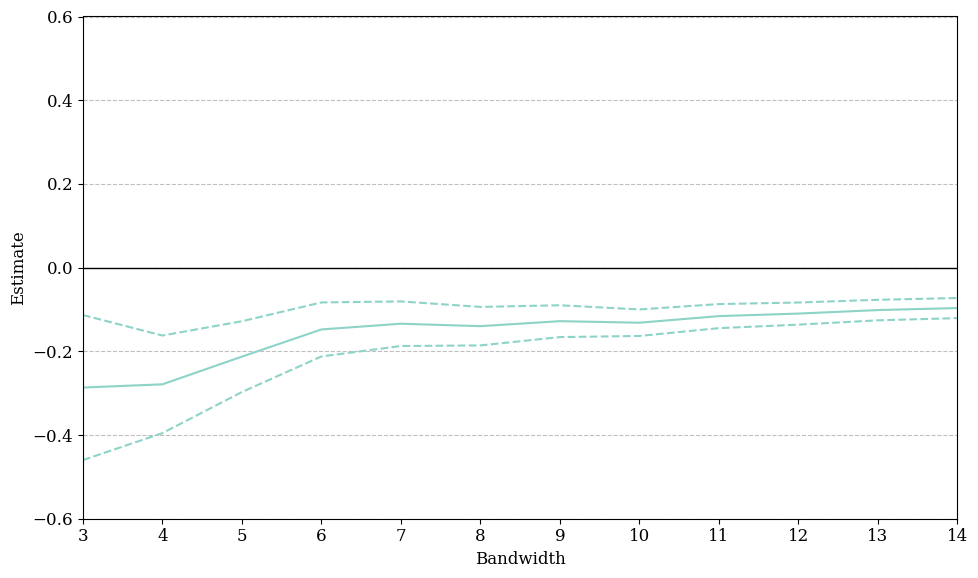

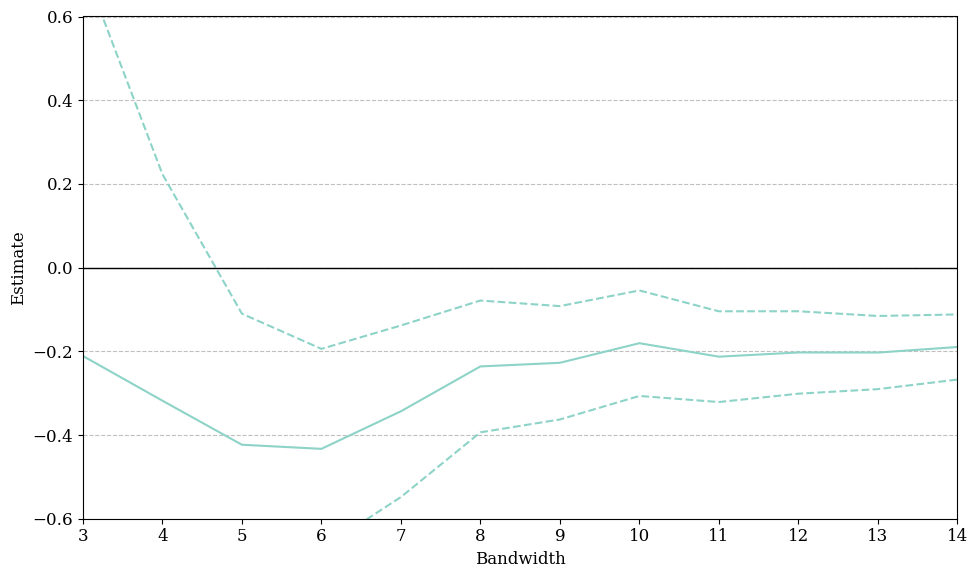

In [11]:
#Plotter first stage first stage
# import exceldata

Fst_lin_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Fst_lin_cl_sogn")
Fst_quad_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Fst_quad_cl_sogn")
Effect_main = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Effect_main")
Effect_lin_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Effect_lin_cl_sogn")
main_storbyer_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "main_storbyer_cl_sogn")
main_u_storbyer_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "main_u_storbyer_cl_sogn")

#Definiting panels with titles
panels = {
    "Fst_lin_cl_sogn": Fst_lin_cl_sogn,
    "Fst_quad_cl_sogn": Fst_quad_cl_sogn,
}

for name, d, in panels.items():
    plot_bw(d, title=name, clr=colors[0], y_min=-0.6, y_max=0.6, ticks=0.2)

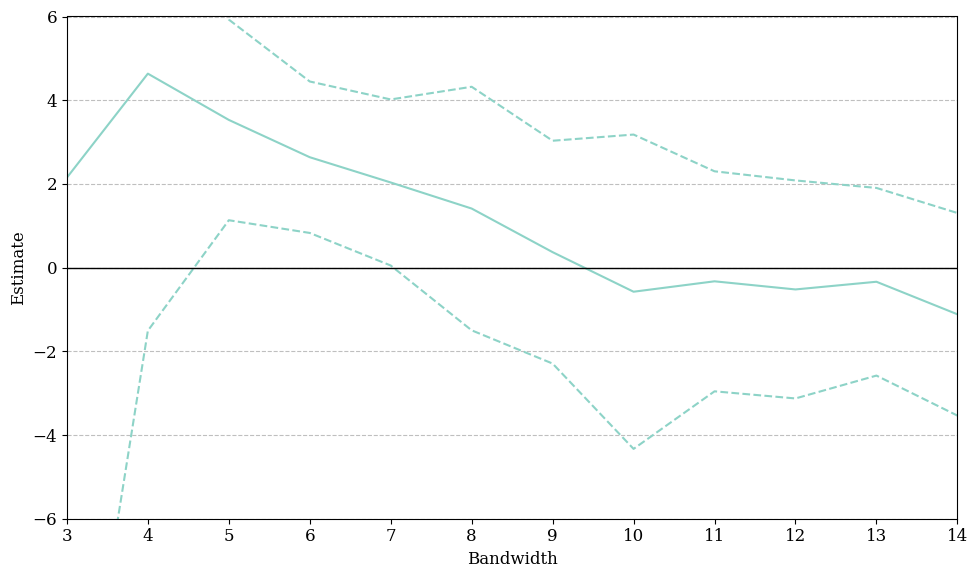

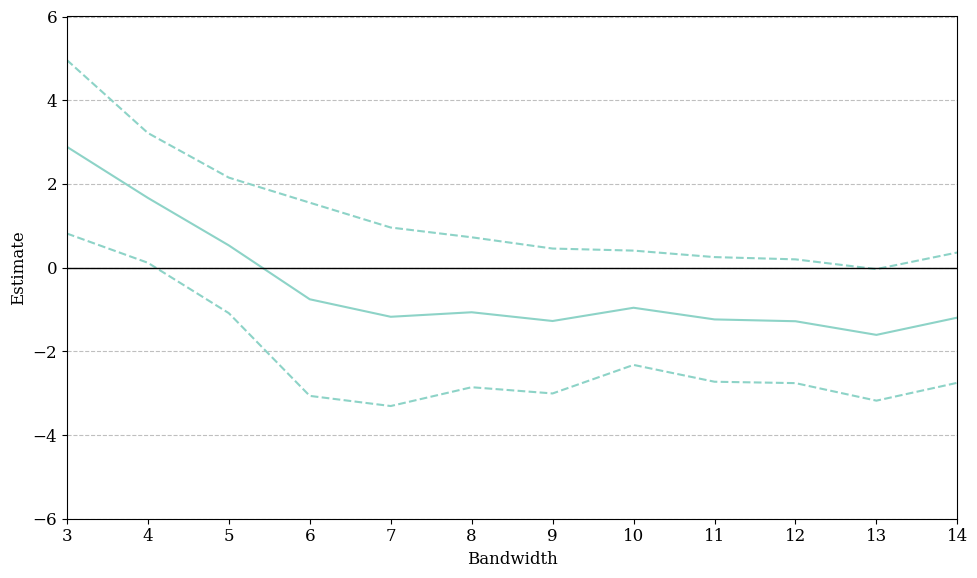

In [12]:
#Plotter second stage first stage
# import exceldata

Fst_lin_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Fst_lin_cl_sogn")
Fst_quad_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Fst_quad_cl_sogn")
Effect_main = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Effect_main")
Effect_lin_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "Effect_lin_cl_sogn")
main_storbyer_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "main_storbyer_cl_sogn")
main_u_storbyer_cl_sogn = load_bw_data("Hjemsendelse 12-11-2025.xlsx", "main_u_storbyer_cl_sogn")

#Definiting panels with titles
panels = {
    "Effect_main": Effect_main,
    "Effect_lin_cl_sogn": Effect_lin_cl_sogn
}

for name, d, in panels.items():
    plot_bw(d, title=name, clr=colors[0],y_min =-6, y_max=6, ticks=2)

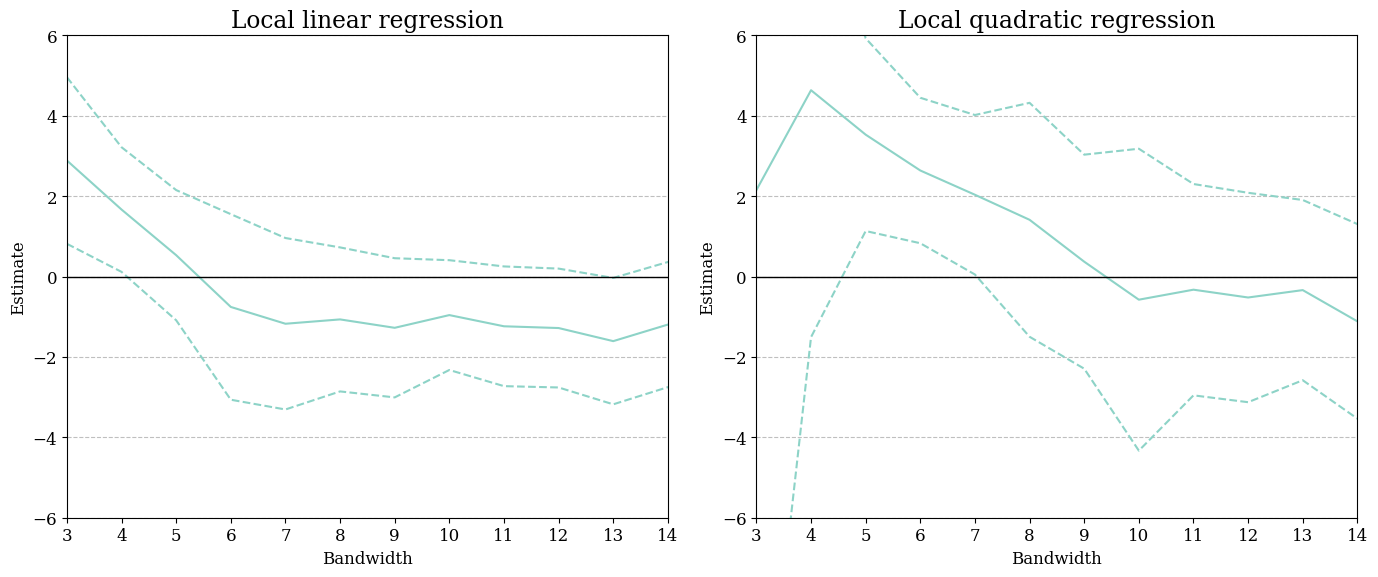

In [ ]:
# Combined bandwidth figure

def plot_bw_combined(df, ax, title="", clr=colors[0], y_min=-5, y_max=5, ticks=1):
    # Plot estimate, upper, lower
    ax.plot(df['est'])
    ax.plot(df['upper'], linestyle='--', color=clr)
    ax.plot(df['lower'], linestyle='--', color=clr)
    ax.axhline(y=0, color='black', linewidth=1)

    ax.set_xlabel("Bandwidth")
    ax.set_ylabel("Estimate")
    ax.set_title(title)

    ax.set_xticks(np.arange(3, 14.01, 1))
    ax.set_xlim(df.index[0], 14)

    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max + 1e-6, ticks))

    ax.grid(axis='x')

fig, axes = plt.subplots(1, 2, figsize=(14,6))

plot_bw_combined(Effect_lin_cl_sogn, ax=axes[0], title="Local linear regression", clr=colors[0], y_min=-6, y_max=6, ticks=2)
plot_bw_combined(Effect_main, ax=axes[1], title="Local quadratic regression", clr=colors[0], y_min=-6, y_max=6, ticks=2)

plt.tight_layout() 
plt.show()



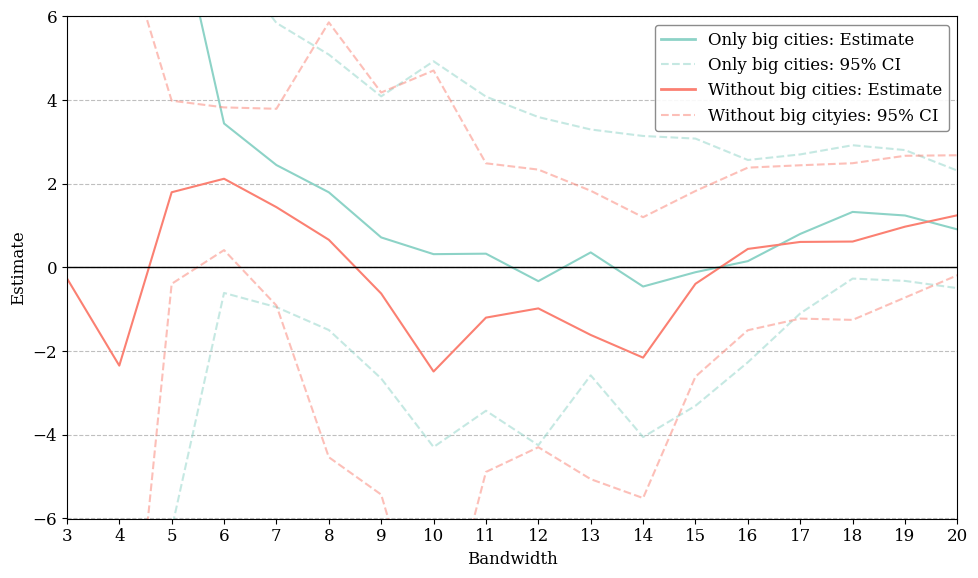

In [13]:
#Defininng size
plt.figure(figsize=(10,6))
alph = 0.5
#plotting for storbyer
plt.plot(main_storbyer_cl_sogn['est'], color=colors[0])
plt.plot(main_storbyer_cl_sogn['upper'], linestyle='--', color=colors[0], alpha = alph)
plt.plot(main_storbyer_cl_sogn['lower'], linestyle='--', color=colors[0], alpha = alph)

#Plotting for uden storbyer
plt.plot(main_u_storbyer_cl_sogn['est'], color=colors[1])
plt.plot(main_u_storbyer_cl_sogn['upper'], linestyle='--', color=colors[1], alpha = alph)
plt.plot(main_u_storbyer_cl_sogn['lower'], linestyle='--', color=colors[1], alpha = alph)

#Plot a fat black horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=1) 

#Plotting legend
storby_est = mlines.Line2D([], [], color=colors[0], label='Only big cities: Estimate', lw=2)
storby_ci  = mlines.Line2D([], [], color=colors[0], linestyle='--', alpha=alph, label='Only big cities: 95% CI')

u_storby_est = mlines.Line2D([], [], color=colors[1], label='Without big cities: Estimate', lw=2)
u_storby_ci  = mlines.Line2D([], [], color=colors[1], linestyle='--', alpha=alph, label='Without big cityies: 95% CI')

plt.legend(handles=[storby_est, storby_ci, u_storby_est, u_storby_ci],
           frameon=True, edgecolor='gray', facecolor='white', framealpha=0.9)


# Formatting
#plt.title("Plot for storbyer og uden storbyer")
plt.xlabel('Bandwidth')
plt.ylabel('Estimate')

#Y-axis ticks
plt.yticks(np.arange(-6, 6.01, 2))
plt.ylim(-6.01,6)

#X-axis ticks
plt.xticks(np.arange(3, 20.01, 1))
plt.xlim(3, 20)

# only horizontal lines
plt.grid(axis='x')   

plt.tight_layout()
plt.show()


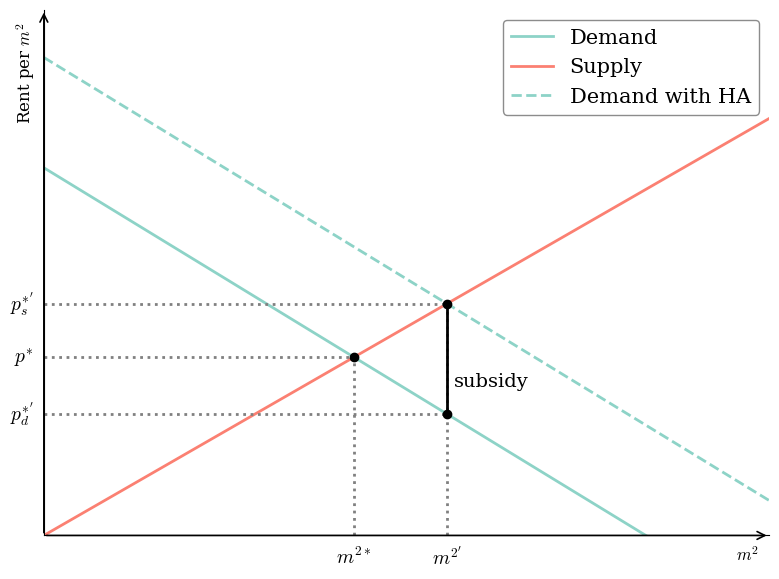

In [14]:
# Subsidy Incidence Diagram — equilibrium shifted left

# --- 1) Steeper curves + tighter intercept gap to push q* left ---
# Demand: p = a - b q
# Supply: p = c + d q
a, b = 10.0, 8.5    # steeper demand
c, d = 0.0, 8.0     # steeper supply, close to demand intercept
s = 3.0             # per-unit subsidy (upward shift in demand)

# --- 2) Equilibria ---
q_star = (a - c) / (b + d)
p_star = c + d * q_star

q_new = (a + s - c) / (b + d)
p_s_new = c + d * q_new           # producer price
p_c_new = p_s_new - s             # consumer price (after subsidy)

# --- 3) Curves for plotting ---
q_max = max(q_new, q_star) * 1.8
q = np.linspace(0, q_max, 400)
D0 = a - b * q
S  = c + d * q
D1 = a + s - b * q

fig, ax = plt.subplots(figsize=(8, 6))

# --- 4) Draw curves ---
ax.plot(q, D0, lw=2, label="Demand")
ax.plot(q, S,  lw=2, label="Supply")
ax.plot(q, D1, lw=2, ls="--", label="Demand with HA", color=colors[0])

# --- 5) Original equilibrium (q*, p*) ---
ax.scatter([q_star], [p_star], color="black", zorder=5)
ax.plot([q_star, q_star], [0, p_star], color="gray", lw=2, ls=":")
ax.plot([0, q_star], [p_star, p_star], color="gray", lw=2, ls=":")
ax.text(q_star, -0.3, r"$m^{2*}$", ha="center", va="top")
ax.text(-0.02, p_star, r"$p^{*}$", ha="right", va="center")

# --- 6) New equilibrium (q', p_c', p_s') ---
ax.scatter([q_new], [p_s_new], color="black", zorder=5)
ax.scatter([q_new], [p_c_new], color="black", zorder=5)
ax.plot([q_new, q_new], [0, p_s_new], color="gray", lw=2, ls=":")
ax.text(q_new, -0.3, r"$m^{2'}$", ha="center", va="top")

ax.plot([0, q_new], [p_c_new, p_c_new], color="gray", lw=2, ls=":")
ax.plot([0, q_new], [p_s_new, p_s_new], color="gray", lw=2, ls=":")
ax.text(-0.02, p_c_new, r"$p_d^{*'}$", ha="right", va="center")
ax.text(-0.02, p_s_new, r"$p_s^{*'}$", ha="right", va="center")

# --- 7) Subsidy wedge at q' ---
ax.plot([q_new, q_new], [p_c_new, p_s_new], color="black", lw=2)
ax.text(q_new + 0.01*q_max, (p_c_new + 0.8*p_s_new) / 2, r"subsidy", va="center")

# --- 9) Axes styling (letters only) ---
ax.set_xlim(0, q_max )
y_min = 0
y_max = max(D1.max(), S.max(), p_s_new) * 1.1
ax.set_ylim(y_min, y_max)
ax.set_xlabel(r"$m^2$")
ax.set_ylabel(r"Rent per $m^2$")
# Move x-label to the far right (end of x-axis)
ax.xaxis.set_label_coords(0.97, -0.02)   # (x, y) in axis coordinates
# Move y-label to the top (end of y-axis)
ax.yaxis.set_label_coords(-0.01, 0.88)   # (x, y) in axis coordinates
ax.set_xticks([])
ax.set_yticks([])

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_position(("data", 0))
ax.spines["left"].set_position(("data", 0))
ax.annotate("", xy=(q_max, 0), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(0, y_max), xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", lw=1.2))

# ax.set_title('Subsidy Incidence')

ax.legend(frameon=True, edgecolor='gray', facecolor='white', framealpha=0.9, fontsize=15)

plt.tight_layout()
plt.show()